## Analysis basics

Introducing possible choices of excitatory cortical layers that are present in the model. It is possible to choose each of them for the analysis.

In [45]:
excitatory_cortical_layers = ["V1_Exc_L4", "V1_Exc_L2/3"]
LAYER = excitatory_cortical_layers[1]

Import of python libraries necessary for analysis

In [46]:
from mozaik.storage.datastore import PickledDataStore
from parameters import ParameterSet
from mozaik.storage.queries import param_filter_query
from mozaik.tools.distribution_parametrization import load_parameters
import logging
import sys
from mozaik.storage.queries import *
from mozaik.analysis.analysis import *
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from mozaik.storage.datastore import DataStoreView
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from scipy.stats import ks_2samp
from matplotlib_venn import venn2, venn2_circles

Function loading simulation data

In [47]:
def load_data_store(path):
    return PickledDataStore(
    load=True,
    parameters=ParameterSet({"root_directory": path, "store_stimuli": False}),
    replace=False,
)

In [48]:
# Path to crashed simulation
# path = "/home/krizanova/mozaik-models/LSV1M/20240222-204307[param.defaults]CombinationParamSearch{trial:[1]}/SelfSustainedPushPull_ParameterSearch_____trial:1/"
path = "/home/krizanova/mozaik-models/LSV1M/20240303-194215[param.defaults]CombinationParamSearch{trial:[2]}/SelfSustainedPushPull_ParameterSearch_____trial:2/"
data_store = load_data_store(path)

In [49]:
# Path to datastore with correct stored neuron positions
# This datastore will not be needed once the simulation runs successfully
# path2 = "/home/rozsa/dev/Julia_analysis/20240301-185354[param.defaults]CombinationParamSearch{trial:[2]}/SelfSustainedPushPull_ParameterSearch_____trial:2"
# ds_pos = load_data_store(path2)

In [50]:
valid_trials = 0
while True:
    try:
        data_store.get_segments()[valid_trials].get_spiketrains()
    except:
        valid_trials -= 1
        break
    valid_trials += 1

Extracts and groups segments, stimuli, and parameters by specified excitatory cortical layers from a given data store, filtering by trial validity and specific stimulus type.

In [51]:
def get_segments_by_cortical_layers(data_store, excitatory_cortical_layers):
    # Retrieve all segments from the data store
    segs_all = data_store.get_segments()
    # Retrieve all stimuli from the data store
    stims_all = data_store.get_stimuli()

    # Initialize dictionaries to store segments, stimuli, and parameters by cortical layer
    segs = {l : [] for l in excitatory_cortical_layers} 
    stims = {l : [] for l in excitatory_cortical_layers}
    params = {l : [] for l in excitatory_cortical_layers}
    # Loop through each segment in the data store
    for i in range(len(segs_all)):
        # Iterate through each specified cortical layer
        for sheet in excitatory_cortical_layers:
            # skip current layer if the required number of valid trials has been reached
            # if len(segs[sheet]) == valid_trials:
            #     continue
            # Check if the segment's sheet name matches and contains a specific stimulus type
            if sheet == segs_all[i].annotations['sheet_name'] and "NaturalImageWithEyeMovement" in stims_all[i]:
                # Append the segment, stimulus, and its parameters to the respective layer's list
                segs[sheet].append(segs_all[i])
                stims[sheet].append(stims_all[i])
                # Load parameters, omitting a substring in the stimulus identifier
                params[sheet].append(load_parameters(stims_all[i].replace("MozaikExtended","")))
    return segs, stims, params

In [52]:
segs, stims, params = get_segments_by_cortical_layers(data_store, excitatory_cortical_layers)
valid_trials = len(segs["V1_Exc_L4"])

Extracts and groups segments, stimuli, and parameters by specified excitatory cortical layers from a given data store, filtering by trial validity and specific stimulus type.

In [53]:
# def plot_neuron_positions(ds_pos, segs, sheet):
#     st_ids = segs[sheet][0].get_stored_spike_train_ids()
#     pos = ds_pos.get_neuron_positions()[sheet][:, ds_pos.get_sheet_indexes(sheet, st_ids)]
#     plt.title("Cortical positions of recorded neurons")
#     plt.plot(pos[0, :], pos[1, :], "ok")
#     plt.xlabel("X (mm)")
#     plt.ylabel("Y (mm)")
#     plt.axis('equal')
#     plt.show()
#     return pos, st_ids

In [54]:
def plot_neuron_positions(data_store, segs, sheet):
    st_ids = segs[sheet][0].get_stored_spike_train_ids()
    pos = data_store.get_neuron_positions()[sheet][:, data_store.get_sheet_indexes(sheet, st_ids)]
    plt.title("Cortical positions of recorded neurons")
    plt.plot(pos[0, :], pos[1, :], "ok")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.axis('equal')
    plt.show()
    return pos, st_ids

The provided code initializes two dictionaries to store spiketrain data and neuron IDs for neurons located within specified excitatory cortical layers.

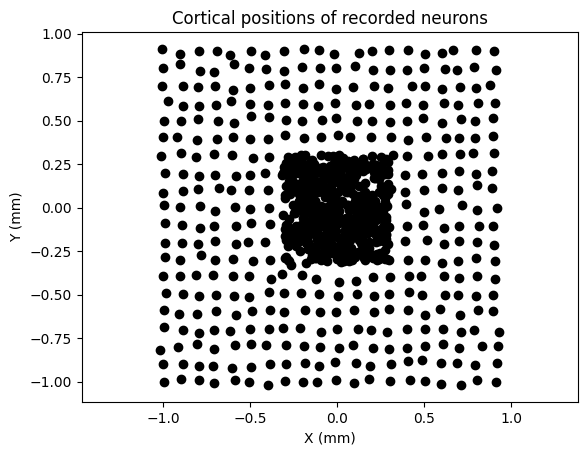

510


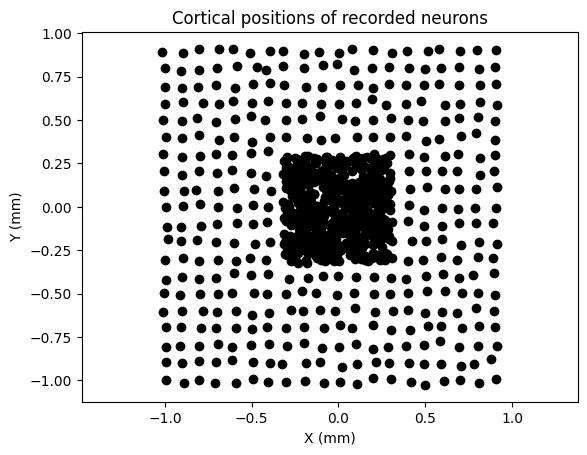

544


In [55]:
spiketrains = {sheet: None for sheet in excitatory_cortical_layers}
neuron_ids = {sheet: None for sheet in excitatory_cortical_layers}

for sheet in excitatory_cortical_layers:
    # pos, st_ids = plot_neuron_positions(ds_pos, segs, sheet)
    pos, st_ids = plot_neuron_positions(data_store, segs, sheet)

    segments = segs[sheet]
    spiketimes = [seg.get_spiketrains() for seg in segments]

    # Get which ids are near the middle of the cortex
    dist = np.sqrt(pos[0, :] ** 2 + pos[1, :] ** 2)
    select_ids = np.where(dist < 0.5)[0]  # 0.5 mm radius
    print(len(select_ids))

    # Get spiketimes for these ids
    filtered_spiketimes = [[st[s_id] for s_id in select_ids] for st in spiketimes]
    neuron_ids[sheet] = np.array(st_ids)[select_ids]
    spiketrains[sheet] = filtered_spiketimes

Visualize the spiking activity of the first two neurons within a specific cortical layer across multiple trials/

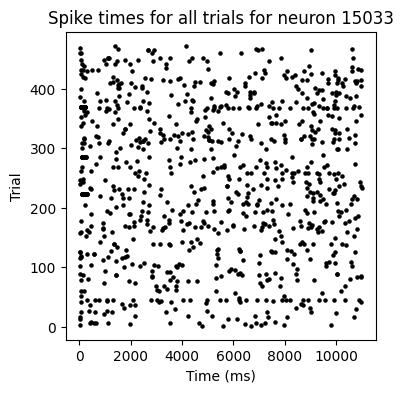

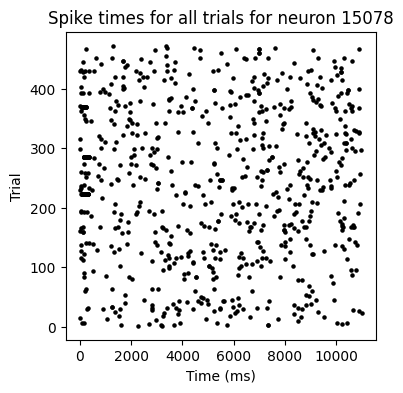

In [56]:
for i in range(2):
    plt.figure(figsize=(4,4))
    for j in range(valid_trials):
        st = spiketrains["V1_Exc_L4"][j][i]
        plt.scatter(st,np.ones_like(st) * params["V1_Exc_L4"][j].trial,s=5,c='k')
    plt.title("Spike times for all trials for neuron %d" % neuron_ids["V1_Exc_L4"][i])
    plt.xlabel("Time (ms)")
    plt.ylabel("Trial")
    plt.show()

Computes the Peristimulus Time Histogram (PSTH) for given spiketrains, organizing the data by trials, neurons, and time bins.

In [57]:
def calculate_psths(spiketrains, bin_size, max_time, valid_trials):
    psth = np.zeros((valid_trials,len(neuron_ids[sheet]),max_time//bin_size))
    for i in range(len(spiketrains[sheet])):
        for j in range(len(spiketrains[sheet][i])):
            for spiketime in spiketrains[sheet][i][j]:
                psth[i,j,int(spiketime)//bin_size] += 1
    return psth

In [58]:
psths = {sheet: None for sheet in excitatory_cortical_layers}
# peristimulus timing histogram, i.e. histogram of spikes
bin_size = 20 # ms
max_time = 12000 # ms
for sheet in spiketrains:
    psth = calculate_psths(spiketrains, bin_size, max_time, valid_trials)
    psths[sheet] = psth / 0.02 # firing rate -> number of spikes per second pre specific neuron and time

## Analysis first part

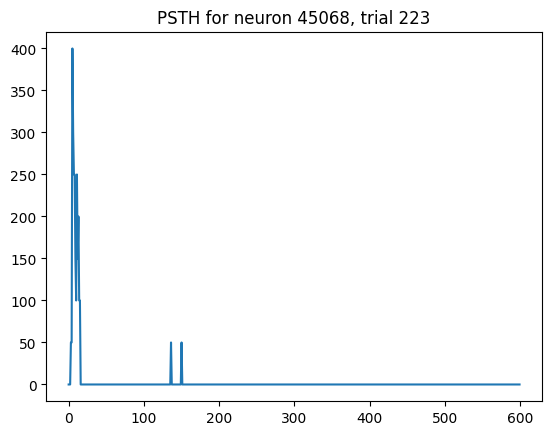

In [59]:
plt.title("PSTH for neuron %d, trial %d" % (neuron_ids[LAYER][0],params[LAYER][168].trial))
plt.plot(psths[LAYER][168,0,:])
plt.show()

This code snippet calculates the grand mean PSTH for the first layer listed in `excitatory_cortical_layers` and visualizes the average firing rate across all neurons and trials within the layer.

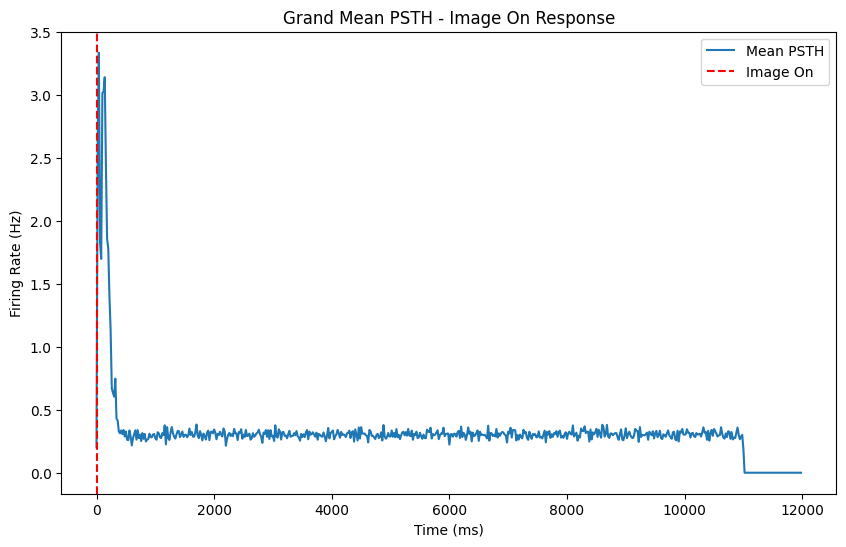

In [60]:
mean_psth = psths[LAYER].mean(axis=(0,1))

time_bins = np.arange(0, mean_psth.shape[0]*bin_size, bin_size)

plt.figure(figsize=(10, 6))
plt.plot(time_bins, mean_psth, label='Mean PSTH')
plt.axvline(x=0, color='r', linestyle='--', label='Image On')  # Assuming time=0 is img_on
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Grand Mean PSTH - Image On Response')
plt.legend()
plt.show()

Extracts and averages PSTH segments for a specific cortical layer following saccade offsets, accounting for image onset, over a defined post-saccade duration.

In [61]:
def get_psth_data(counter, post_saccade_duration, filename, layer, bin_size, psths, num_trials):
    psth_data = np.zeros([psths[layer].shape[1], post_saccade_duration // bin_size]) #pocet neuronov * cas
    
    for trial_id in range(1, num_trials + 1):
        trial_label = f"/trial{trial_id}"
        # with h5py.File(f"{datadir}/{data_filename}", 'r') as data:
        with h5py.File(filename, 'r') as data:
            t_img_on = data[trial_label+"/image_onset_time"][...]
            ts_sac_off = data[trial_label+"/saccade_offset_times"][...]
            
            for ts_sac in ts_sac_off:
                segment_start = ts_sac - t_img_on
                if segment_start < 0:
                    continue
                segment_end = segment_start + post_saccade_duration  # 300ms post-saccade
                # index in psths when the saccade ended, so the second place where the monkey is looking began
                segment_start_idx = segment_start // bin_size 
                segment_end_idx = segment_end // bin_size
    
                if segment_end_idx >= psths[layer].shape[-1]-1: # time
                    continue
                
                psth_data += psths[layer][trial_id-1,:,int(segment_start_idx):int(segment_end_idx)]
                counter+=1
                
    psth_data /= counter
    return psth_data

Data loading

In [62]:
basedir = "/projects/nextcloud_data/csng_test/files/Latency_shortening"
datadir = os.path.join(basedir, "data")
data_filename = "HIME_20140904_rec5_blk2_eye_position.hdf5"
file = "/home/krizanova/mozaik-models/HIME_20140904_rec5_blk2_eye_position.hdf5"
# with h5py.File(f"{datadir}/{data_filename}", 'r') as data:
# with h5py.File(file, 'r') as data:
#     num_trials = data['/number_of_trials'][...]
    # num_trials=337
num_trials = valid_trials

counter = 0
post_saccade_duration = 500
psth_data = get_psth_data(counter, post_saccade_duration, file, LAYER, bin_size, psths, num_trials)

Calculates the mean PSTH across all neurons from previously prepared PSTH data (`psth_data`) and visualizes the average firing rate over time.

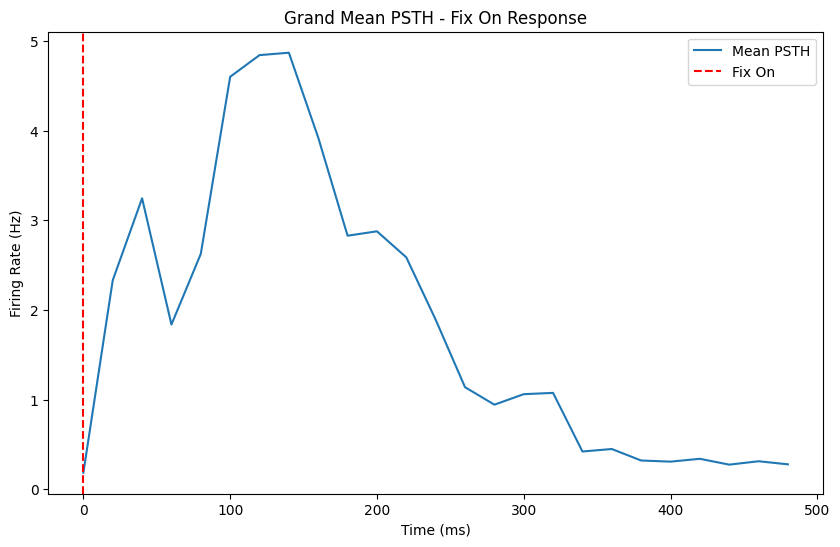

In [63]:
mean_psth = psth_data.mean(axis=(0))

time_bins = np.arange(0, mean_psth.shape[0]*bin_size, bin_size)

plt.figure(figsize=(10, 6))
plt.plot(time_bins, mean_psth, label='Mean PSTH')
plt.axvline(x=0, color='r', linestyle='--', label='Fix On')  # Assuming time=0 is img_on
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Grand Mean PSTH - Fix On Response')
plt.legend()
plt.show()

In [64]:
contrained_psth_img_on = psths[LAYER][:, :, :500//bin_size]
psth_img_on = psths[LAYER].mean(axis=0)

Processing of PSTH data (`psth_img_on`) to extract and visualize the median PSTH and its interquartile range, highlighting the variability of neuronal firing rates around key time points.

In [65]:
summed_psth = np.sum(psth_img_on, axis=1)
sorted_indices = np.argsort(summed_psth, axis=None)
median_index = sorted_indices[len(sorted_indices) // 2]
q1_index = sorted_indices[len(sorted_indices) // 4]
q3_index = sorted_indices[len(sorted_indices) * 3 // 4]

In [66]:
# time_bins = np.arange(0, psth_img_on.shape[1] * bin_size, bin_size)

# plt.figure(figsize=(10, 6))
# plt.plot(time_bins, psth_img_on[median_index], label='Median PSTH', color='orange')
# plt.fill_between(time_bins, psth_img_on[q1_index], psth_img_on[q3_index], color='orange', alpha=0.5, label='Interquartile Range')
# plt.axvline(x=0, color='r', linestyle='--', label='Time of Event')
# plt.xlim(0,500)
# plt.xlabel('Time (ms)')
# plt.ylabel('Firing Rate (Hz)')
# plt.title('Median PSTH with Interquartile Range img on')
# plt.legend()
# plt.show()

In [67]:
# np argsort through every time moment
sorted_indices = np.argsort(psth_img_on, axis=0)
median_index = sorted_indices[len(sorted_indices) // 2,:]
q1_index = sorted_indices[len(sorted_indices) // 4,:]
q3_index = sorted_indices[len(sorted_indices) * 3 // 4,:]

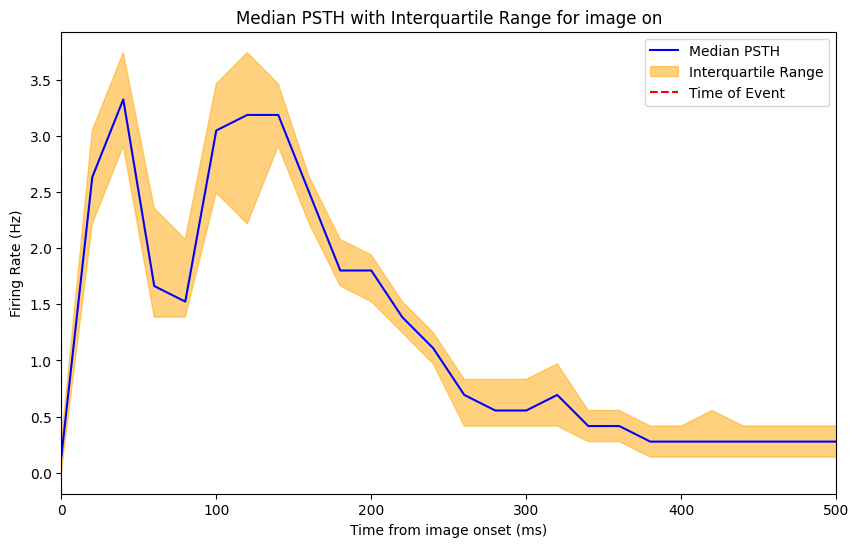

In [68]:
time_bins = np.arange(0, psth_img_on.shape[1] * bin_size, bin_size)

plt.figure(figsize=(10, 6))
plt.plot(time_bins, psth_img_on[median_index,range(psth_img_on.shape[1])], label='Median PSTH', color='blue')
plt.fill_between(time_bins, psth_img_on[q1_index, range(psth_img_on.shape[1])], psth_img_on[q3_index, range(psth_img_on.shape[1])], color='orange', alpha=0.5, label='Interquartile Range')
plt.axvline(x=0, color='r', linestyle='--', label='Time of Event')
plt.xlim(0,500)
plt.xlabel('Time from image onset (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Median PSTH with Interquartile Range for image on')
plt.legend()
plt.show()

Visualization of the firing rate variability of neurons over time with respect to a fixation-onset event, focusing on the median and interquartile range (IQR) of the PSTH data.

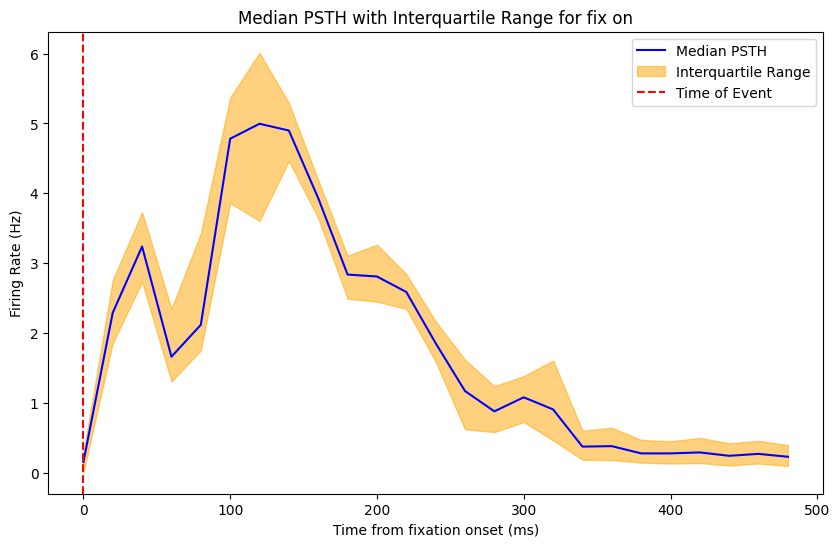

In [69]:
# 2) fix on histogram
sorted_indices = np.argsort(psth_data, axis=0)

median_index = sorted_indices[len(sorted_indices) // 2,:] # indices of neurons for every time moment
q1_index = sorted_indices[len(sorted_indices) // 4,:]
q3_index = sorted_indices[len(sorted_indices) * 3 // 4,:]
time_bins = np.arange(0, psth_data.shape[1] * bin_size, bin_size)

plt.figure(figsize=(10, 6))
plt.plot(time_bins, psth_data[median_index,range(psth_data.shape[1])], label='Median PSTH', color='blue')
plt.fill_between(time_bins, psth_data[q1_index, range(psth_data.shape[1])], psth_data[q3_index, range(psth_data.shape[1])], color='orange', alpha=0.5, label='Interquartile Range')
plt.axvline(x=0, color='r', linestyle='--', label='Time of Event')
plt.xlabel('Time from fixation onset (ms)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Median PSTH with Interquartile Range for fix on')
plt.legend()
plt.show()
psth_fix_on = psth_data

## Second part of the analysis - responsiveness of neurons

In [70]:
path = "/home/krizanova/new_mozaik-models/mozaik-models/LSV1M/20240409-155153[param.defaults]CombinationParamSearch{trial:[2]}/SelfSustainedPushPull_ParameterSearch_____trial:2"
spont_ds = load_data_store(path)

In [71]:
# Only select layer 4 excitatory neuron recordings
spont_ds_exc = param_filter_query(data_store, sheet_name=LAYER)

spiketimes = spont_ds_exc.get_segments()[0].get_spiketrains()
psth_spont = np.zeros((len(spiketimes),10000 // bin_size)) # neurons x time bins

for i in range(len(spiketimes)):
    for spiketime in spiketimes[i]:
        sp_idx = int(spiketime)// bin_size
        if sp_idx < psth_spont.shape[1]:
            psth_spont[i,sp_idx] += 1
psth_spont /= (bin_size / 1000)

In [72]:
def get_psth_fix_on_data(counter, post_saccade_duration, filename, layer, bin_size, psths, num_trials):
    # psth_data = np.zeros([psths[layer].shape[1], post_saccade_duration // bin_size])
    psth_fix_on_data = []
    for trial_id in range(1, num_trials + 1):
        trial_label = f"/trial{trial_id}"
        # with h5py.File(f"{datadir}/{data_filename}", 'r') as data:
        with h5py.File(filename, 'r') as data:
            t_img_on = data[trial_label+"/image_onset_time"][...]
            ts_sac_off = data[trial_label+"/saccade_offset_times"][...]
            
            for ts_sac in ts_sac_off:
                segment_start = ts_sac - t_img_on
                if segment_start < 0:
                    continue
                segment_end = segment_start + post_saccade_duration
                # index in psths when the saccade ended, so the second place where the monkey is looking began
                segment_start_idx = segment_start // bin_size
                segment_end_idx = segment_end // bin_size
    
                if segment_end_idx >= psths[layer].shape[-1]-1: # time
                    continue
                
                psth_fix_on_data.append(psths[layer][trial_id-1,:,int(segment_start_idx):int(segment_end_idx)])
                counter+=1
                
    psth_fix_on_data = np.array(psth_fix_on_data)
    return psth_fix_on_data

In [73]:
psth_fix_on_data = get_psth_fix_on_data(counter, post_saccade_duration, file, LAYER, bin_size, psths, num_trials)

Calculate the mean and the standard deviation of the spontaneous activity.

In [74]:
mean_activity = np.mean(psth_spont)
std_activity = np.std(psth_spont)

print(mean_activity)
print(std_activity)

0.39931113662456946
4.496601547019081


Calculating the total number of image on responsive neurons.

In [75]:
# def psth_spont_compared_to_img_on_peak_distrib(psth_spont, psths, layer):
#     psth_spont_flat = psth_spont.flatten()
#     img_on_peak_distribution = psths[layer].max(axis=-1)
    
#     psth_img_on_data_mean = np.mean(psths[layer], axis=0)
#     max_positions_img_on = psth_img_on_data_mean.argmax(axis=-1)
#     # print(max_positions_img_on.shape)
#     img_on_peak_distribution = np.array([psths[layer][:, i, max_positions_img_on[i]] for i in range(len(max_positions_img_on))]).T
#     # print(img_on_peak_distribution.shape)
#     num_neurons = img_on_peak_distribution.shape[1]
#     statistics = np.zeros(num_neurons)
#     p_values = np.zeros(num_neurons)
#     img_on_responsive_neurons = []
    
#     alpha = 0.05
#     for i in range(num_neurons):
#         one_neuron = img_on_peak_distribution[:, i]
#         statistics[i], p_values[i] = ks_2samp(one_neuron, psth_spont_flat)
        
#         if p_values[i] < alpha: # reject H0 -> neuron is responsive
#             img_on_responsive_neurons.append(i)
    
#     print(f"Total responsive neurons: {len(img_on_responsive_neurons)} out of {num_neurons}")
#     return img_on_responsive_neurons, img_on_peak_distribution

In [76]:
# img_on_responsive_neurons, img_on_peak_distribution = psth_spont_compared_to_img_on_peak_distrib(psth_spont, psths, LAYER)

Calculating the total number of fix on responsive neurons and visualizing histogram of spontaneous psth, as well as fix on peak distribution histogram.

In [77]:
# def psth_spont_compared_to_fix_on_peak_distrib(psth_spont, psths, layer, psth_fix_on_data):
#     fix_on_peak_distribution = psth_fix_on_data.max(axis=-1)
#     psth_fix_on_data_mean = np.mean(psths[layer], axis=0)
#     max_positions_fix_on = psth_fix_on_data_mean.argmax(axis=-1)
#     # print(max_positions_img_on.shape)
#     fix_on_peak_distribution = np.array([psths[layer][:, i, max_positions_fix_on[i]] for i in range(len(max_positions_fix_on))]).T
#     psth_spont_flat = psth_spont.flatten()
#     num_neurons = fix_on_peak_distribution.shape[1]
#     statistics = np.zeros(num_neurons)
#     p_values = np.zeros(num_neurons)
#     fix_on_responsive_neurons = []
    
#     alpha = 0.05
#     for i in range(num_neurons):
#         one_neuron = fix_on_peak_distribution[:, i]
#         statistics[i], p_values[i] = ks_2samp(one_neuron, psth_spont_flat)
        
#         if p_values[i] < alpha: # reject H0 -> neuron is responsive
#             fix_on_responsive_neurons.append(i)

#     plt.hist(psth_spont_flat)
#     plt.show()
#     plt.hist(fix_on_peak_distribution.flatten())
#     plt.show()
#     print(f"Total responsive neurons: {len(fix_on_responsive_neurons)} out of {num_neurons}")
#     return fix_on_responsive_neurons, fix_on_peak_distribution, num_neurons

In [78]:
def psth_spont_compared_to_peak_distrib(psth_spont, psths, layer, psth_data):
    peak_distribution = psth_data.max(axis=-1)
    psth_data_mean = np.mean(psths[layer], axis=0)
    max_positions = psth_data_mean.argmax(axis=-1)
    peak_distribution = np.array([psths[layer][:, i, max_positions[i]] for i in range(len(max_positions))]).T
    psth_spont_flat = psth_spont.flatten()
    num_neurons = peak_distribution.shape[1]
    statistics = np.zeros(num_neurons)
    p_values = np.zeros(num_neurons)
    responsive_neurons = []
    
    alpha = 0.05
    for i in range(num_neurons):
        one_neuron = peak_distribution[:, i]
        statistics[i], p_values[i] = ks_2samp(one_neuron, psth_spont_flat)
        
        if p_values[i] < alpha: # reject H0 -> neuron is responsive
            responsive_neurons.append(i)

    plt.hist(psth_spont_flat)
    plt.show()
    plt.hist(peak_distribution.flatten())
    plt.show()
    print(f"Total responsive neurons: {len(responsive_neurons)} out of {num_neurons}")
    return responsive_neurons, peak_distribution, num_neurons

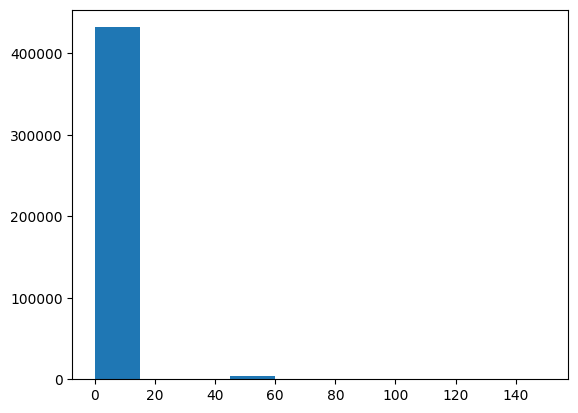

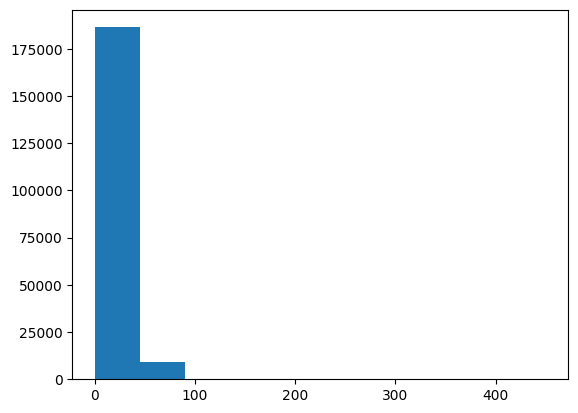

Total responsive neurons: 91 out of 544


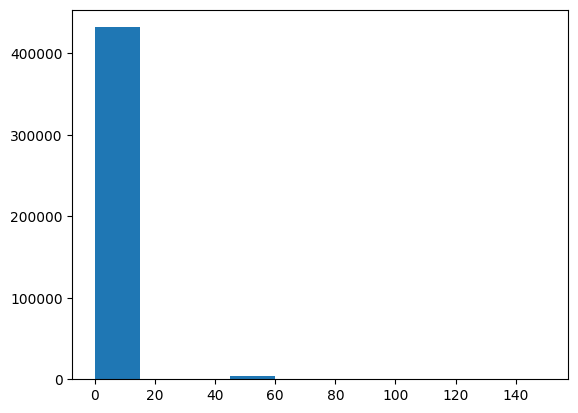

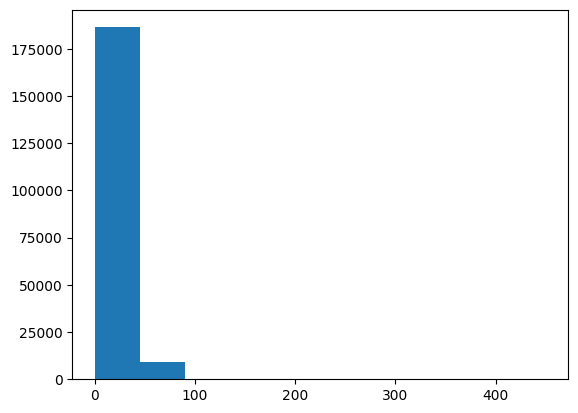

Total responsive neurons: 91 out of 544


In [79]:
img_on_responsive_neurons, img_on_peak_distribution, num_neurons = psth_spont_compared_to_peak_distrib(psth_spont, psths, LAYER, psths[LAYER])
fix_on_responsive_neurons, fix_on_peak_distribution, num_neurons = psth_spont_compared_to_peak_distrib(psth_spont, psths, LAYER, psth_fix_on_data)

In [80]:
# fix_on_responsive_neurons, fix_on_peak_distribution, num_neurons = psth_spont_compared_to_fix_on_peak_distrib(psth_spont, psths, LAYER, psth_fix_on_data)

Plotting venn diagram to visualize the responsiveness of neurons to fix on and to image on.

In [81]:
def plot_venn_diagram(num_neurons, fix_on_responsive_neurons, img_on_responsive_neurons):
    fix_on_set = set(fix_on_responsive_neurons)
    img_on_set = set(img_on_responsive_neurons)
    
    fx_on_only = len(fix_on_set - img_on_set)
    img_on_only = len(img_on_set - fix_on_set)
    doubly_responsive = len(fix_on_set & img_on_set)
    
    total_units = num_neurons
    non_responsive = total_units - (img_on_only + fx_on_only + doubly_responsive)

    # Plotting
    plt.figure(figsize=(4, 4))
    venn_diagram = venn2(subsets=(fx_on_only, img_on_only, doubly_responsive), set_labels=('Rose (fix-on)', 'Gray (img-on)'))
    venn_diagram.get_patch_by_id('10').set_color('lightpink')
    venn_diagram.get_patch_by_id('01').set_color('lightgray')
    venn_diagram.get_patch_by_id('11').set_color('purple')

    plt.title("Layer units")
    plt.annotate(f'Non-responsive: {non_responsive}', xy=(0.5, -0.2), xycoords='axes fraction', ha='center')
    plt.show()

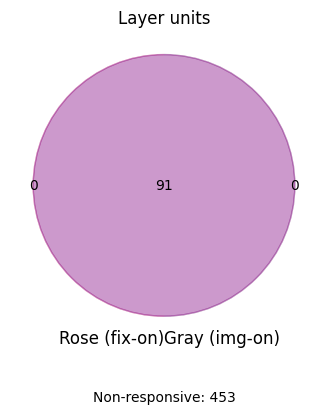

In [82]:
plot_venn_diagram(num_neurons, fix_on_responsive_neurons, img_on_responsive_neurons)

## Third part of the analysis

Generating a scatter plot comparing the neuronal response latencies following image onset to those following fixation onset.

In [83]:
def create_scatterplot(psth_fix_on_data, bin_size, psths, layer):
    psth_fix_on_data_argmax = psth_fix_on_data.argmax(axis=-1) * bin_size
    contrained_psth_img_on = psths[layer][:, :, :500//bin_size]
    psth_img_on_latency = contrained_psth_img_on.argmax(axis=-1) * bin_size
    img_on_latencies = psth_img_on_latency.mean(axis=0)
    fix_on_latencies = psth_fix_on_data_argmax.mean(axis=0)
    
    plt.figure(figsize=(5, 5))
    plt.scatter(img_on_latencies, fix_on_latencies, alpha=0.5, edgecolors='w', color='blue')
    
    plt.xlabel('Latency from image onset (ms)')
    plt.ylabel('Latency from fixation onset (ms)')
    plt.title('Scatter Plot of Response Latencies: Img-on vs. Fix-on')
    plt.show()

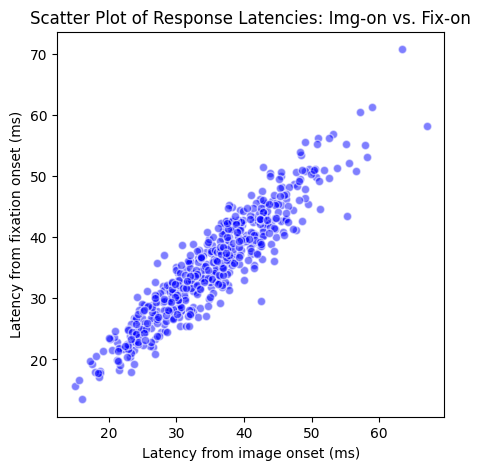

In [84]:
create_scatterplot(psth_fix_on_data, bin_size, psths, LAYER)

## Fourth part of the analysis

Computing the sparseness of neuronal responses based on their Peristimulus Time Histograms (PSTH).

In [85]:
def calculate_sparseness(psth):
    N = psth.shape[1] 
    sparseness_values_for_all_neurons = np.zeros(psth.shape[0])
    
    for i, neuron_psth in enumerate(psth):
        a = ((np.sum(neuron_psth) / N)**2) / (np.sum(neuron_psth**2) / N)
        S = (1 - a) / (1 - 1/N)
        sparseness_values_for_all_neurons[i] = S
    
    return sparseness_values_for_all_neurons

In [86]:
psth_spont_sparseness = calculate_sparseness(psth_spont)
img_on_sparseness = calculate_sparseness(img_on_peak_distribution)
fix_on_sparseness = calculate_sparseness(fix_on_peak_distribution)

/tmp/ipykernel_648410/2586379523.py:6: RuntimeWarning: invalid value encountered in double_scalars
  a = ((np.sum(neuron_psth) / N)**2) / (np.sum(neuron_psth**2) / N)


Plotting sparseness histogram for image on and for fixation on spraseness.

In [87]:
def plot_sparseness_histogram(sparseness_values, title):
    median_value = np.median(sparseness_values)
    print(len(sparseness_values))
    plt.figure()
    plt.hist(sparseness_values, bins=np.linspace(0,1,21), color='red', alpha=0.7)
    plt.axvline(median_value, color='black', linestyle='dashed', linewidth=2)
    plt.text(median_value + 0.02, plt.gca().get_ylim()[1] * 0.9, f'Median: {median_value:.2f}',
             rotation=0, color='black')
    plt.title(title)
    plt.xlabel('Sparseness')
    plt.ylabel('Count')
    plt.show()

361


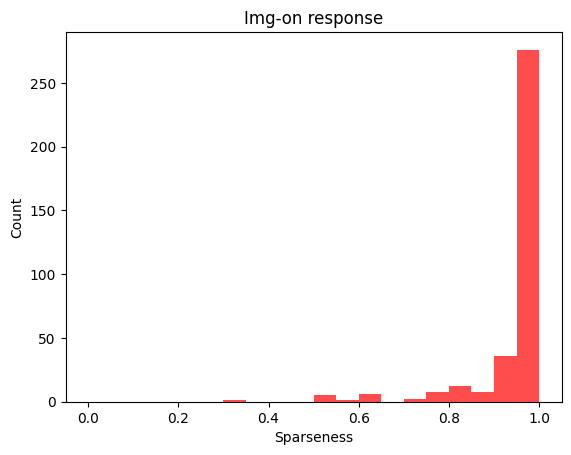

361


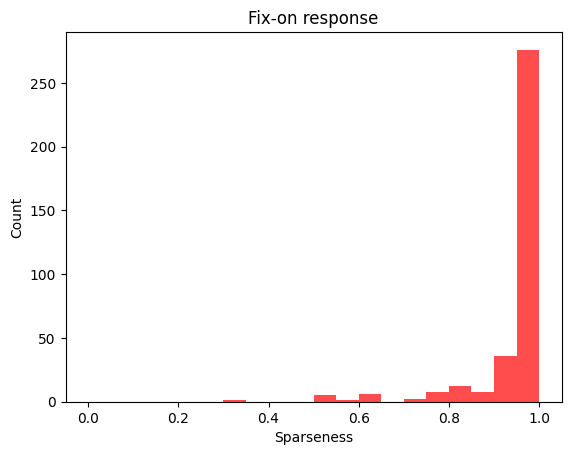

In [88]:
plot_sparseness_histogram(img_on_sparseness, 'Img-on response')
plot_sparseness_histogram(fix_on_sparseness, 'Fix-on response')